### <Font color = 'indianred'>**Setting up the environment**

In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 93.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


In [2]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

# !pip uninstall transformers
# !pip install -U transformers
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, AutoModel
from transformers import AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import DataCollatorWithPadding
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
from transformers import pipeline
import evaluate

# wandb library
import wandb

In [20]:
base_folder = Path('/content/drive/MyDrive/NLP/HW_6')
data_folder = base_folder
model_folder = base_folder/'Models'
custom_functions = base_folder/'custom_functions'

In [21]:
model_folder.mkdir(exist_ok=True, parents = True)

In [22]:
model_folder

PosixPath('/content/drive/MyDrive/NLP/HW_6/Models')

### <Font color = 'indianred'>**Load Data** </font>

In [23]:
import pandas as pd
train_df = pd.read_csv(data_folder / 'train.csv')

### <Font color = 'indianred'>**Check for distribution of word length per tweet** </font>

In [24]:
# check distribution of text length
train_df['words_per_Tweet'] = train_df['Tweet'].str.split().apply(len)

<Axes: >

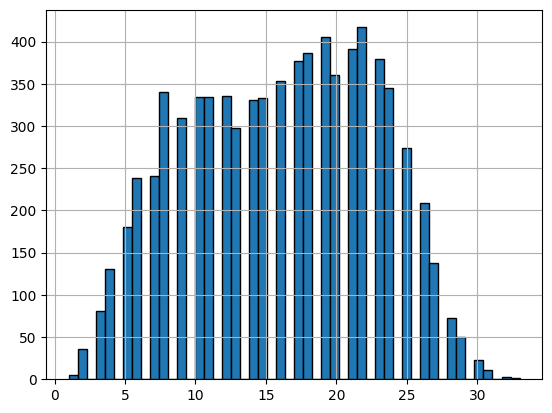

In [25]:
# Plot a histogram of the 'words_per_review' column
train_df['words_per_Tweet'].hist(bins=50, edgecolor='black')

### <Font color = 'indianred'>**Splitting and converting into dictionary** </font>

### <Font color = 'indianred'>**Running on smaller set of data due to memory issues** </font>

In [26]:
from sklearn.model_selection import train_test_split

train_df_reduced = train_df.sample(frac=0.05, random_state=42)

X = train_df_reduced['Tweet'].tolist()
y = train_df_reduced[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.astype(np.float32).tolist()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


print("Training set length:", len(X_train), len(y_train))
print("Validation set length:", len(X_valid), len(y_valid))
print("Test set length:", len(X_test), len(y_test))

Training set length: 202 202
Validation set length: 68 68
Test set length: 116 116


In [27]:
######### Check without converting text to labels
# from sklearn.model_selection import train_test_split
# X = train_df['Tweet'].tolist()
# y = train_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.astype(np.float32).tolist()

# X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


# print("Training set length:", len(X_train), len(y_train))
# print("Validation set length:", len(X_valid), len(y_valid))
# print("Test set length:", len(X_test), len(y_test))

### <Font color = 'indianred'>**Converting one-hot encoded labels to text** </font>

In [28]:
from datasets import load_dataset, DatasetDict
# Define label names based on the order of your one-hot encoded vectors
label_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Function to convert one-hot encoded labels to a comma-separated string of labels
def one_to_label_text(labels, label_names):
    label_texts = []
    for label_vector in labels:
        # Get the label names for indices where there is a 1
        label_text = ', '.join([label_names[i] for i, is_present in enumerate(label_vector) if is_present == 1])
        label_texts.append(label_text)
    return label_texts

# Convert the labels for training, validation, and test sets
train_labels_text = one_to_label_text(y_train, label_names)
valid_labels_text = one_to_label_text(y_valid, label_names)
test_labels_text = one_to_label_text(y_test, label_names)

# Update the datasets with the textual labels
trainset = Dataset.from_dict({
    'texts': X_train,
    'labels': train_labels_text
})

validset = Dataset.from_dict({
    'texts': X_valid,
    'labels': valid_labels_text
})

testset = Dataset.from_dict({
    'texts': X_test,
    'labels': test_labels_text
})

# Combine training and validation sets into a DatasetDict for convenience
train_val = DatasetDict({"train": trainset, "valid": validset})


In [29]:
# View the first few labels from the training set
print("Training set labels:")
for i in range(3):  # Adjust the range to view more or fewer examples
    print(train_val['train'][i]['labels'])

# View the first few labels from the validation set
print("\nValidation set labels:")
for i in range(3):  # Adjust the range to view more or fewer examples
    print(train_val['valid'][i]['labels'])


Training set labels:
disgust, pessimism, sadness
anticipation, optimism, sadness
anger, disgust

Validation set labels:
anger, disgust, fear, pessimism
anger, disgust, fear
optimism


In [30]:
# print("Type of y_train labels:", type(y_train.iloc[0]))
# print("Type of y_valid labels:", type(y_valid.iloc[0]))
# print("Type of y_test labels:", type(y_test.iloc[0]))


### <Font color = 'indianred'>**Preprocessing data** </font>

In [31]:
from transformers import T5Tokenizer
checkpoint = "google/flan-t5-base"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [32]:
def tokenize_fn(batch):
    # Tokenize the texts with consistent padding
    tokenized_input = tokenizer(
        batch["texts"],
        truncation=True,
        padding="max_length",
        max_length=512,  # This is fine for input texts.
        return_tensors="pt"
    )

    tokenized_labels = tokenizer(
        batch["labels"],
        truncation=True,
        padding="max_length",
        max_length=128,  # This should be enough for a few labels concatenated as a single string.
        return_tensors="pt"
    )
    return {
        "input_ids": tokenized_input["input_ids"],
        "attention_mask": tokenized_input["attention_mask"],
        "labels": tokenized_labels["input_ids"]
    }


In [33]:
tokenized_datasets = train_val.map(tokenize_fn, batched=True, remove_columns=['texts', 'labels'])
tokenized_datasets.set_format('torch', columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/202 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

### <Font color = 'indianred'>**Defining the model** </font>

In [34]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, T5Config
model = T5ForConditionalGeneration.from_pretrained(checkpoint, num_labels = 11)  # We are using the same checkpiont as we have used for tokenizer


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [35]:
config = T5Config.from_pretrained(checkpoint)
config.problem_type = "multi_label_classification"
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
id2label= {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_: id_ for id_, label_ in enumerate(class_names)}
config.id2label = id2label
config.label2id = label2id
model.config = config

In [36]:
config

T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_

In [37]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseGatedActDense(
              (wi_0): Linear(in_features=768, out_features=2048, bias=False)
              (wi_1): Linear(in_features=768, out_features=2048, bias=False)
              (wo):

In [38]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # Assuming the first element of the tuple is what we need if logits is a tuple
    logits = logits[0] if isinstance(logits, tuple) else logits

    # Convert logits to a PyTorch tensor if not already
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(logits, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities >= 0.5).float()

    # Ensure labels are on the correct device and are tensors
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, device=predictions.device)

    # Move tensors to CPU and convert to numpy for sklearn calculations
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    predictions = predictions[:, :, 0]
    # Check shapes before calculating metrics
    print(f"Predictions Shape: {predictions.shape}, Labels Shape: {labels.shape}")
    # Ensure both are flattened properly if necessary
    predictions = predictions.flatten()
    labels = labels.flatten()

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    hamming = hamming_loss(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming
    }


In [53]:
import torch
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, hamming_loss

def compute_metrics2(eval_pred):
    logits, labels = eval_pred
    # Assuming the first element of the tuple is what we need if logits is a tuple
    logits = logits[0] if isinstance(logits, tuple) else logits

    # Convert logits to a PyTorch tensor if not already
    if not isinstance(logits, torch.Tensor):
        logits = torch.tensor(logits, device='cuda' if torch.cuda.is_available() else 'cpu')

    # Apply sigmoid to get probabilities
    probabilities = torch.sigmoid(logits)
    predictions = (probabilities >= 0.5).float()

    # Ensure labels are on the correct device and are tensors
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels, device=predictions.device)

    # Move tensors to CPU and convert to numpy for sklearn calculations
    predictions = predictions.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    # Check shapes before calculating metrics
    print(f"Predictions Shape: {predictions.shape}, Labels Shape: {labels.shape}")
    # Ensure both are flattened properly if necessary
    predictions = predictions.flatten()
    labels = labels.flatten()

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)
    precision = precision_score(labels, predictions, average='macro', zero_division=0)
    recall = recall_score(labels, predictions, average='macro', zero_division=0)
    hamming = hamming_loss(labels, predictions)

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'hamming_loss': hamming
    }


### <Font color = 'indianred'>**Training the model** </font>

In [39]:
# Define the directory where model checkpoints will be saved
run_name = "Multilabel Project with google/flan-t5-base model"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=3,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    #gradient_accumulation_steps=2,
    # auto_find_batch_size=True,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=10,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=10,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=10,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,


)


In [40]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [41]:
wandb.login()
%env WANDB_PROJECT = multilabel_bert

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=multilabel_bert


In [ ]:
# import torch
# torch.cuda.empty_cache()

In [42]:
# import os
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = "expandable_segments:True"


trainer.train()

wandb: Currently logged in as: prafulp659 (utd659). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Hamming Loss,Runtime,Samples Per Second,Steps Per Second
10,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,4.960400,13.709000,1.814000
20,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,5.077800,13.392000,1.772000
30,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,4.586000,14.828000,1.962000
40,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,4.801000,14.164000,1.875000
50,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,4.784700,14.212000,1.881000
60,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,4.191800,16.222000,2.147000
70,0.000000,nan,0.955193,0.057475,0.056188,0.058824,0.044807,4.135800,16.442000,2.176000


Predictions Shape: (68, 128), Labels Shape: (68, 128)
Predictions Shape: (68, 128), Labels Shape: (68, 128)
Predictions Shape: (68, 128), Labels Shape: (68, 128)
Predictions Shape: (68, 128), Labels Shape: (68, 128)
Predictions Shape: (68, 128), Labels Shape: (68, 128)
Predictions Shape: (68, 128), Labels Shape: (68, 128)
Predictions Shape: (68, 128), Labels Shape: (68, 128)


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=78, training_loss=0.0, metrics={'train_runtime': 137.5021, 'train_samples_per_second': 4.407, 'train_steps_per_second': 0.567, 'total_flos': 414962955583488.0, 'train_loss': 0.0, 'epoch': 3.0})

In [43]:
eval_results = trainer.evaluate(tokenized_datasets["valid"])

Predictions Shape: (68, 128), Labels Shape: (68, 128)


In [44]:
eval_results

{'eval_loss': nan,
 'eval_accuracy': 0.9551930147058824,
 'eval_f1': 0.057475475793796194,
 'eval_precision': 0.05618782439446367,
 'eval_recall': 0.058823529411764705,
 'eval_hamming_loss': 0.04480698529411765,
 'eval_runtime': 4.3943,
 'eval_samples_per_second': 15.475,
 'eval_steps_per_second': 2.048,
 'epoch': 3.0}

In [45]:
wandb.log({"eval_accuracy": eval_results["eval_accuracy"], "eval_loss": eval_results["eval_loss"], "eval_f1": eval_results["eval_f1"]})

In [46]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 10.


### <Font color = 'indianred'>**Evaluating the model on test set through checkpoint** </font>

In [47]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/data/models/Multilabel Project with google/flan-t5-base model/checkpoint-10'

In [48]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/data/models/Multilabel Project with google/flan-t5-base model/checkpoint-10 and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [49]:
test_set_tokenized = testset.map(tokenize_fn, batched=True)

Map:   0%|          | 0/116 [00:00<?, ? examples/s]

In [50]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [54]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_set_tokenized,
    compute_metrics=compute_metrics2,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
test_results= trainer.evaluate()

In [ ]:
test_results

In [ ]:
wandb.log({"test_accuracy": test_results["eval_accuracy"], "test_loss": test_results["eval_loss"], "test_f1": test_results["eval_f1"]})

In [ ]:
wandb.finish()

### <Font color = 'indianred'>**Inference** </font>

In [ ]:
text = "I'm stressed about the experiment 3 where i need to use Flan T5 model"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

In [ ]:
logits = outputs.logits
logits.shape

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)